# Handling data truncation (i.e. selection functions)

Investigate the problem of dealing with a selection function by simulating data from a 1D Gaussian and truncating these above some limiting value. Try to infer the correct mean and standard deviation.

## The data

The data $D = \{x_i\}$, $i=1\ldots N$, are generated according to the a normal distribution with mean $\mu$ and standard deviation $\sigma$:

\begin{equation}
    p(x_i\mid\mu,\sigma) = {\cal N}(x_i\mid\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}
    e^{-\frac{1}{2}\left(\frac{x_i-\mu}{\sigma}\right)^2} \,,
\end{equation}

where values $x_i>x_\mathrm{lim}$ are not observed, leaving $K\leq N$ data points in the sample, and it is assumed that $x_\mathrm{lim}$ is known (for example magnitude limited survey with a known magnitude limit). This means that more than the $K$ data values are in principle available but we only have access to the $K$ points in the set $\{x_k\}$, $k=1\ldots K$. In the case of Gaia, for example, this arises because on board the spacecraft a decision is taken (based on the measured flux of the source at detection) to discard sources for which $G>20.7$.

The example below uses $\mu=3$, $\sigma=1$ and $x_\mathrm{lim}=2$. This means that the data are quite severely truncated (only about 15 per cent making it into the sample).

## 'Fitting' a Gaussian

In the absence of data truncation one could write down the posterior distribution of $\mu$ and $\sigma$, given the data, as

\begin{equation}
    p(\mu,\sigma\mid D) = \frac{\prod_{i=1}^N p(x_i\mid\mu,\sigma)p(\mu,\sigma)}{p(D)}\,.
\end{equation}

If no priors on $\mu$ and $\sigma$ are used the posterior can be shown to equal

\begin{equation}
    p(\mu,\sigma\mid D) = \sqrt{\frac{N}{\pi}} \frac{2\sqrt{2}}{\Gamma\left(\frac{N-2}{2}\right)} 
    \frac{1}{NV} \left(\frac{NV}{2\sigma^2}\right)^{N/2}
    \exp\left(-\frac{NV+n(\mu-\bar{x})^2}{2\sigma^2}\right)\,,
\end{equation}

which is normalized, and where $\bar{x}$ is the mean of $\{x_n\}$ and

\begin{equation}
    V = \frac{\sum_i\left(x_i-\bar{x}\right)^2}{N}\,,
\end{equation}

is the data variance (as opposed to the sample variance $S=NV/(N-1)$). The maximum a posteriori estimates of $\mu$ and $\sigma$ are $\bar{x}$ and $\sqrt{V}$, which in this case equal the maximum likelihood estimates. Note that this refers to maximum of the _joint_ posterior. The maxima of the marginalized posterior distributions for $\mu$ and $\sigma$ are at $\bar{x}$ and $\sqrt{S}$. Thus a straightforward maximum likelihood fit of a Gaussian to the data $D$ will result in a best-fit Gaussian with mean $\bar{x}$ and standard deviation $\sqrt{V}$. Hence if this method is naively applied to the truncated data the values of $\mu$ and $\sigma$ will always be underestimated. This is illustrated in the next code block. It simulates the truncated data and then plots the contours of the posterior above (i.e. the likelihood contours, with the likelihood considered a function of $\mu$ and $\sigma$).

Note how the truth is very far outside the $99.994$ per cent ('4-sigma', outer contour in the right panel) confidence region. The likelihood contours would in fact give false confidence in a precise result if no model checking is done. A comparison of the maximum likelihood model and the data (left panel) of course immediately reveals the problem of underestimation of $\mu$ and $\sigma$.

In [2]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
from scipy.stats import norm
from scipy.special import erf
from scipy.integrate import simps

from mpl_toolkits.axes_grid1.colorbar import colorbar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from mcmcplotting import convert_to_stdev_nan
from plotstyles import useagab, apply_tufte

import corner
from stantools import load_stan_code, stan_cache

Number of points in truncated data set: 17
Data mean: 1.31
Data standard deviation: 0.60


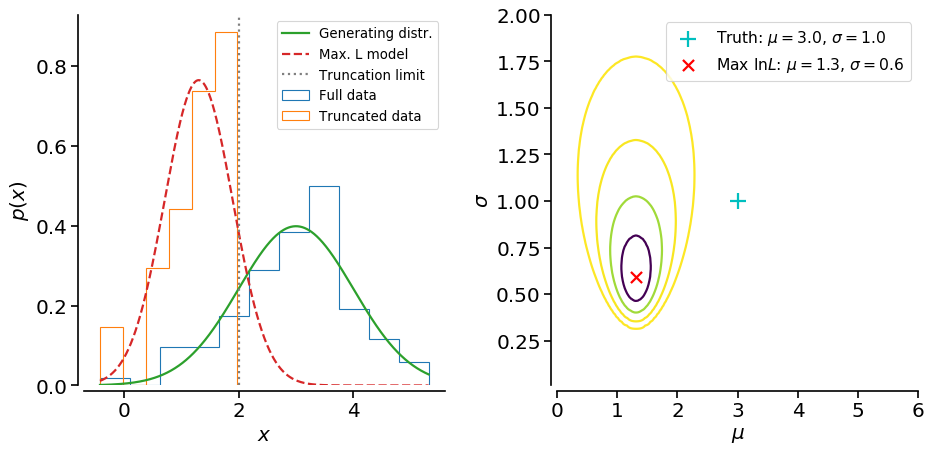

In [8]:
ndata = 100
mu = 3.0
sigma = 1.0
xlim = 2.0 # truncate data to x<xlim
xfull = norm.rvs(loc=mu, scale=sigma, size=ndata)
xtrunc = xfull[(xfull < xlim)]
print("Number of points in truncated data set: {0}".format(xtrunc.size))

mm = np.linspace(mu-3*sigma, mu+3*sigma,6*50)
ss = np.linspace(0.01,2*sigma,2*50)
m, s = np.meshgrid(mm, ss)
lnL = np.zeros_like(m)
for x in xtrunc:
    lnL = lnL + norm.logpdf(x, loc=m, scale=s)
maxindices = np.unravel_index(np.argmax(lnL),lnL.shape)
mubest = m[maxindices]
sigmabest = s[maxindices]

useagab(usetex=False, fontfam='sans', sroncolours=False)
fig = plt.figure(figsize=(12,6))

axA = fig.add_subplot(1,2,1)
apply_tufte(axA)
axB = fig.add_subplot(1,2,2)
apply_tufte(axB)

axA.hist(xfull, bins='auto', histtype='step', normed=True, label='Full data')
axA.hist(xtrunc, bins='auto', histtype='step', normed=True, label='Truncated data')
z = np.linspace(xfull.min(), xfull.max(), 1000)
axA.plot(z, norm.pdf(z, loc=mu, scale=sigma), label='Generating distr.')
axA.plot(z, norm.pdf(z, loc=mubest, scale=sigmabest) / norm.cdf(xlim, loc=mubest, scale=sigmabest), 
         label='Max. L model', ls='--')
axA.axvline(x=xlim, ls=':', color='gray', label="Truncation limit")
axA.set_xlabel(r'$x$')
axA.set_ylabel(r'$p(x)$')
axA.legend(fontsize=12, loc='upper right')

slevels = erf(np.array([1,2,3,4])/np.sqrt(2))
axB.contour(mm, ss, convert_to_stdev_nan(lnL), levels=slevels)
axB.scatter(mu, sigma, marker='+', c='c', s=200.0, label='Truth: $\mu={0:.1f}$, $\sigma={1:.1f}$'.format(mu,sigma))
axB.scatter(mubest, sigmabest, marker='x', c='r', s=100.0, 
            label=r'Max $\ln L$: $\mu={0:.1f}$, $\sigma={1:.1f}$'.format(mubest,sigmabest))
axB.set_xlabel(r'$\mu$')
axB.set_ylabel(r'$\sigma$')
axB.legend(fontsize=14)

print("Data mean: {0:.2f}".format(xtrunc.mean()))
print("Data standard deviation: {0:.2f}".format(xtrunc.std()))

plt.tight_layout()
plt.show()

## Taking the data truncation into account

The truncation of the data can be handled by realizing the that likelihood for a given $x_k$in the above posterior is given by a truncated normal distribtuion:

\begin{equation}
    p(x_k\mid \mu,\sigma;x_\mathrm{lim}) \propto
    \begin{cases}
        {\cal N}(x_k\mid \mu,\sigma) & x\leq x_\mathrm{lim}\\
        0 & x>x_\mathrm{lim}
    \end{cases}\,,
\end{equation}

where $x_\mathrm{lim}$ is a fixed known parameter. The normalization of this probability distribution is

\begin{equation}
    \int_{-\infty}^{x_\mathrm{lim}} \frac{1}{\sigma\sqrt{2\pi}}
    e^{-\frac{1}{2}\left(\frac{x_k-\mu}{\sigma}\right)^2} \,dx_k =
    \int_{-\infty}^{\frac{x_\mathrm{lim}-\mu}{\sigma}}
    \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}y^2} \,dy =
    \Phi\left(\frac{x_\mathrm{lim}-\mu}{\sigma}\right) =
    \frac{1}{2} \left(1 + \mathrm{erf}\left( \frac{x_\mathrm{lim}-\mu}{\sigma\sqrt{2}} \right)\right)\,,
\end{equation}

with $\Phi(t)$ the cumulative standard normal distribution and the error function (erf) is defined as

\begin{equation}
    \mathrm{erf}(z) = \frac{2}{\sqrt{\pi}}\int_0^z e^{-t^2}\,dt\,.
\end{equation}

Note that in the function $\Phi(t)$ can be accessed through the `cdf` or `logcdf` functions of `scipy.stats.norm`. The full posterior now becomes

\begin{equation}
    p(\mu,\sigma\mid \mathbf{x}) \propto p(\mu,\sigma) \Phi\left(\frac{x_\mathrm{lim}-\mu}{\sigma}\right)^{-K}
    \prod_{k=1}^K {\cal N}(x_k\mid \mu,\sigma)\,.
\end{equation}

In this case one cannot get away with improper (not normalized) priors on $\mu$ and $\sigma$, as otherwise the posterior is not normalized (this statement is not obvious mathematically but is confirmed by inspection of the likelihood surface and by MCMC sampling experiments which do not converge to the correct posterior region without constraints from a normalized prior). In this case simple vague and independent priors are chosen: $p(\mu) = {\cal N}(\mu \mid  0, 5)$ and $p(\sigma) = {\cal N}_\frac{1}{2}(\sigma\mid 0,3)$, where ${\cal N}_\frac{1}{2}$ stands for the half-normal distribution for $\sigma>0$.

Plotting this posterior as a function of $\mu$ and $\sigma$ is done in the following code block. The right panel shows the resulting likelihood contours overplotted on the value of the normalization term above. The effect of the normalization term is to rescale the likelihood such that the correct values of $\mu$ and $\sigma$ are now well within the $99$ per cent confidence level (even if point estimates of the parameter values can still be quite far off numerically). The right panel shows that now the maximum posterior probability parameters lead to a plausible model given the data (this is not to say that the MAP estimate of the parameters provides the best model for the data!).

A few remarks:
* In this problem the estimates of $\mu$ and $\sigma$ are correlated because of the distorted probability contours. The correlation can be understood from the fact that the limited information on the full distribution (where it is not known where $x_\mathrm{lim}$ is with respect to $\mu$) allows for a narrow Gaussian with $\mu$ within the data range or a broad Gaussian with $\mu$ outside the data range.
* When experimenting with different realizations of the observed data, the marginal distributions of both $\mu$ and $\sigma$ can have more than one peak, reflecting the point just made about the ambiguous information in the data.
* The normalization of the likelihood (here a truncated normal) is essential to correctly deal with truncated data!
* Proper (normalized) priors are needed, even if they are very vague. It is in fact instructive to play with the priors and see the effect of making them less informative (by increasing the scale of the normal distributions). Note how the true values of $\mu$ and $\sigma$ stay within the '1-sigma' confidence level, even if the posterior means in some realizations of the data drift far away from the truth as the prior becomes less important (especially for $\mu$).
* The mode of $p(\mu,\sigma\mid D)$ is well defined but most of the time does not provide a good estimate of the true values of $\mu$ and $\sigma$ (unless one has a large amount of data).
* The priors on $\mu$ and $\sigma$ above were chosen without really using the information in the data. From the fact that $x_\mathrm{lim}$ represents an _upper limit_ to the data values one can already infer that the data mean $\bar{x}$ must be a lower limit on $\mu$ (although some error margin on $\bar{x}$ must be accounted for) and likewise the data variance $V$ is a lower limit on the actual variance. This information could be use to construct vague priors that take the lower limits on $\mu$ and $\sigma$ into account.

/home/brown/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


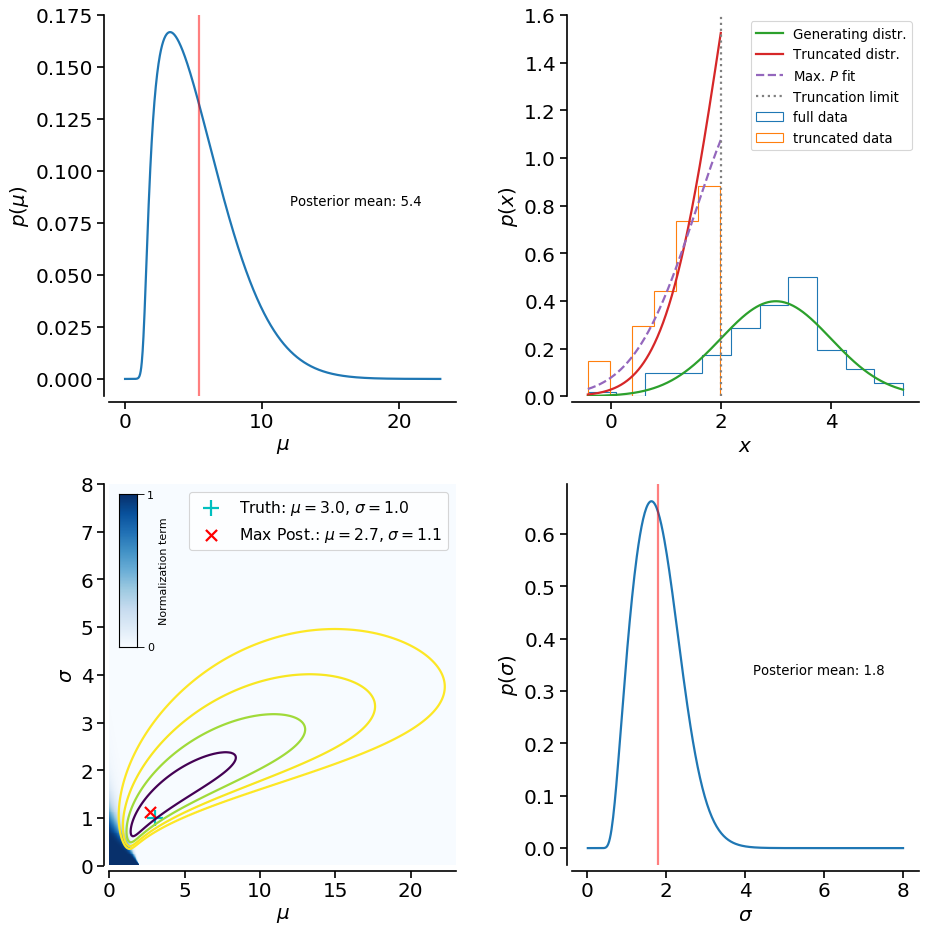

In [9]:
mm = np.linspace(mu-3*sigma, mu+20*sigma,23*50)
ss = np.linspace(0.01,8*sigma,8*50)
m, s = np.meshgrid(mm, ss)

lnMuPrior = norm.logpdf(m, loc=0, scale=5)
lnSigmaPrior = norm.logpdf(s, loc=0, scale=3) + np.log(2)
normalizationL = xtrunc.size*norm.logcdf(xlim, loc=m, scale=s)

lnL = np.zeros_like(m)
for x in xtrunc:
    lnL = lnL + norm.logpdf(x, loc=m, scale=s)

lnPosterior = lnL - normalizationL + lnMuPrior + lnSigmaPrior
maxindices = np.unravel_index(np.nanargmax(lnPosterior),lnPosterior.shape)

posterior = np.exp(lnPosterior)
marginalPosteriorMu = simps(posterior, s, axis=0)
marginalPosteriorMu = marginalPosteriorMu/simps(marginalPosteriorMu, mm)
marginalPosteriorSigma = simps(posterior, m, axis=1)
marginalPosteriorSigma = marginalPosteriorSigma/simps(marginalPosteriorSigma, ss)

posteriorMeanMu = simps(mm*marginalPosteriorMu, mm)
posteriorMeanSigma = simps(ss*marginalPosteriorSigma, ss)

fig = plt.figure(figsize=(12,12))

useagab(usetex=False, fontfam='sans', sroncolours=False)
axA = fig.add_subplot(2,2,2)
apply_tufte(axA)
axB = fig.add_subplot(2,2,3)
apply_tufte(axB)
axC = fig.add_subplot(2,2,1)
apply_tufte(axC)
axD = fig.add_subplot(2,2,4)
apply_tufte(axD)

mubest = m[maxindices]
sigmabest = s[maxindices]

axA.hist(xfull, bins='auto', histtype='step', normed=True, label='full data')
axA.hist(xtrunc, bins='auto', histtype='step', normed=True, label='truncated data')
z = np.linspace(xfull.min(), xfull.max(), 1000)
axA.plot(z, norm.pdf(z, loc=mu, scale=sigma), label='Generating distr.')
z = np.linspace(xfull.min(), xlim, 1000)
axA.plot(z, norm.pdf(z, loc=mu, scale=sigma)/norm.cdf(xlim,loc=mu,scale=sigma), 
         label='Truncated distr.')
axA.plot(z, norm.pdf(z, loc=mubest, scale=sigmabest) / 
         norm.cdf(xlim, loc=mubest, scale=sigmabest), label='Max. $P$ fit', ls='--')
axA.axvline(x=xlim, ls=':', color='gray', label="Truncation limit")
axA.set_xlabel(r'$x$')
axA.set_ylabel(r'$p(x)$')
axA.legend(fontsize=12, loc='upper right')

slevels = erf(np.array([1,2,3,4])/np.sqrt(2))
im = axB.imshow(np.exp(normalizationL), cmap='Blues', aspect='auto', 
           extent=[mm.min(), mm.max(), ss.min(), ss.max()], origin='lower')
axB.contour(mm, ss, convert_to_stdev_nan(lnPosterior), levels=slevels)
axB.scatter(mu, sigma, marker='+', c='c', s=200.0, label='Truth: $\mu={0:.1f}$, $\sigma={1:.1f}$'.format(mu,sigma))
axB.scatter(mubest, sigmabest, marker='x', c='r', s=100.0, 
            label=r'Max Post.: $\mu={0:.1f}$, $\sigma={1:.1f}$'.format(mubest,sigmabest))
axB.set_xlabel(r'$\mu$')
axB.set_ylabel(r'$\sigma$')
axB.legend(fontsize=14)
caxB = inset_axes(axB, "5%", "40%", loc='upper left')
cb = colorbar(im, cax=caxB, ticks=[0,1], orientation="vertical")
caxB.yaxis.set_ticks_position('right')
caxB.yaxis.set_label_position('right')
caxB.yaxis.set_tick_params(labelsize=10)
caxB.set_ylabel('Normalization term', fontsize=10, family='sans')

axC.plot(mm, marginalPosteriorMu)
axC.axvline(x=posteriorMeanMu, c='r', alpha=0.5)
axC.text(0.9, 0.5, "Posterior mean: {0:.1f}".format(posteriorMeanMu), horizontalalignment='right', 
         transform=axC.transAxes, fontsize=12)
axC.set_xlabel(r'$\mu$')
axC.set_ylabel(r'$p(\mu)$')

axD.plot(ss, marginalPosteriorSigma)
axD.axvline(x=posteriorMeanSigma, c='r', alpha=0.5)
axD.text(0.9, 0.5, "Posterior mean: {0:.1f}".format(posteriorMeanSigma), horizontalalignment='right', 
         transform=axD.transAxes, fontsize=12)
axD.set_xlabel(r'$\sigma$')
axD.set_ylabel(r'$p(\sigma)$')

plt.tight_layout()
plt.show()

## MCMC version of the solution

Although there is no strict need to resort to Markov Chain Monte Carlo methods for this problem (the full likelihood as a function of $\mu$ and $\sigma$ can be calculated) it is nevertheless interesting to understand how to model this problem in MCMC terms. In addition the generated samples give (easier) access to other point estimates for $\mu$ and $\sigma$ such as the mean, median, etc. The code block below implements an MCMC sampling of the likelihood above using PyStan.

The Stan code for this problem is:
```
data {
    real xlimit;    // Sample values are truncated above this (known) limit.
    int<lower=0> K; // Number of samples available after truncation.
    vector[K] x;    // List of samples.
}

transformed data {
}

parameters {
    real mu;             // Mean of normal distribution.
    real<lower=0> sigma; // Standard deviation of normal distribution.
}

transformed parameters {
}

model {
    mu ~ normal(0, 5);                     // Prior on mu
    sigma ~ normal(0, 3);                  // Prior on sigma
    for (k in 1:K)
        x[k] ~ normal(mu, sigma) T[,xlimit]; // Likelihood for x[k], truncated at xlimit.
}
```

Using cached StanModel
Inference for Stan model: anon_model_7f2e1d62f37cd2610c7a232d769f0129.
4 chains, each with iter=50000; warmup=25000; thin=5; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      5.36    0.03   2.38   2.46   3.56   4.77   6.59   11.3   8622    1.0
sigma    1.4  4.4e-3   0.39    0.8   1.09   1.34   1.65   2.26   7749    1.0
lp__   92.96  9.6e-3   1.04  90.21  92.53  93.26  93.71  94.02  11919    1.0

Samples were drawn using NUTS at Wed Jan  3 18:43:36 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


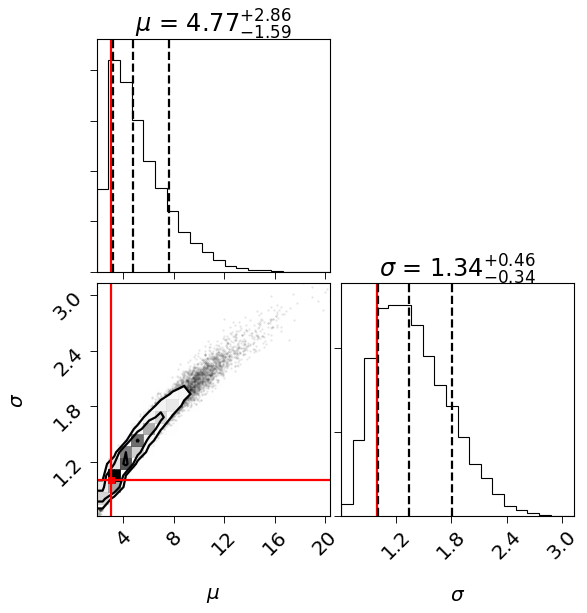

In [10]:
stan_data = {'xlimit':xlim, 'K':xtrunc.size, 'x':xtrunc}
stanmodel = load_stan_code("truncated_data.stan")
sm = stan_cache(stanmodel, model_name="simpleDataTruncation")
fit = sm.sampling(data = stan_data, pars=['mu', 'sigma'], iter=50000, chains=4, thin=5)
print(fit)

samples = np.vstack([fit.extract()['mu'], fit.extract()['sigma']]).transpose()
    
fig = plt.figure(figsize=(8,8))
ax = []
for i in range(1,5):
    ax.append(fig.add_subplot(2,2,i))
corner.corner(samples, labels=[r'$\mu$', r'$\sigma$'], truths=[mu, sigma],
              truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=fig)
plt.show()